# Time-series inversion basic example

This notebook shows how to extract a cumulative displacement time-series from a network of pairwise displacement measurements through inversion using a synthetic signal as example. Initially we will work with a network of perfect measurements and then experiment with the addition of different types of measurement errors.

In [1]:
# load neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from itertools import combinations
import random

#import functions for time-series inversion from relevant python script
import timeseries_inversion as inv

## Error-free example

As a first example, we will create a synthetic displacement time-series and sample this signal for different date pairs. These are then used in the inversion process to reconstruct the original signal. 

Text(0, 0.5, 'Displacement')

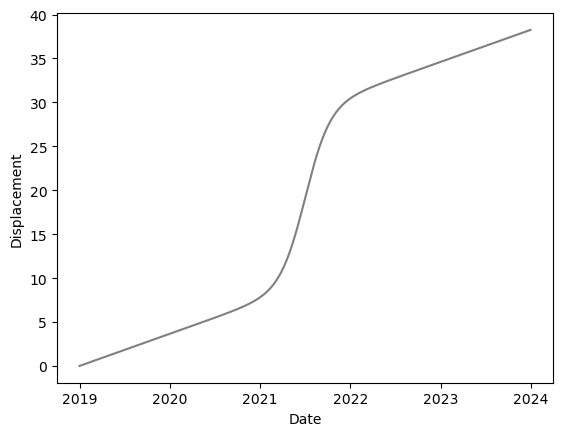

In [2]:
#create an artificial displacement original_signal
start_date = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_date = datetime.strptime('31/12/2023', '%d/%m/%Y')

dr = pd.date_range(start=start_date, end=end_date, freq='D')


#create synthetic cumulative displacement original_signal
#here: sigmoid + linear function
x = np.arange(0, len(dr), 1)
y = 0.01 * x + 20 / (1 + np.exp(-0.02 * (np.arange(len(dr)) - len(dr)/2)))

#alternatives:
#quadratic function
#y = 0.0000007 * (x**2) * 0.007 * x 

#linear + sine wave
#y = 0.01 * x + 1 * np.sin(2 * np.pi * x / 365)

original_signal = pd.DataFrame({'date': dr, 'disp': y})

plt.figure()
plt.plot(original_signal.date, original_signal.disp, 'gray')
plt.xlabel('Date')
plt.ylabel('Displacement')

In [3]:
# define dates on which to sample the displacement signal (usually dates of satellite acquisitions)

# option 1: regular sampling every 3 months
sample_dates = pd.date_range(start=start_date, end=end_date, freq='3MS')

#option 2: irregular sampling by drawing a 30 random dates from the date range defined earlier 
#comment out if not needed
random.seed(123)
sample_dates = random.sample(list(dr), 30)
sample_dates.append(start_date) #make sure start date is included
sample_dates.sort()

#create image pairs from sample dates
date_combinations = list(combinations(sample_dates, 2))

network = pd.DataFrame(date_combinations, columns=['date0', 'date1'])

#find displacement for each datepair according to the synthetic signal
network['disp'] = network.apply(lambda row: inv.find_dsoll(row, original_signal), axis = 1)

#run inversion
timeseries = inv.run_inversion(network)

Number of image pairs: 465
Number of groups in network: 1


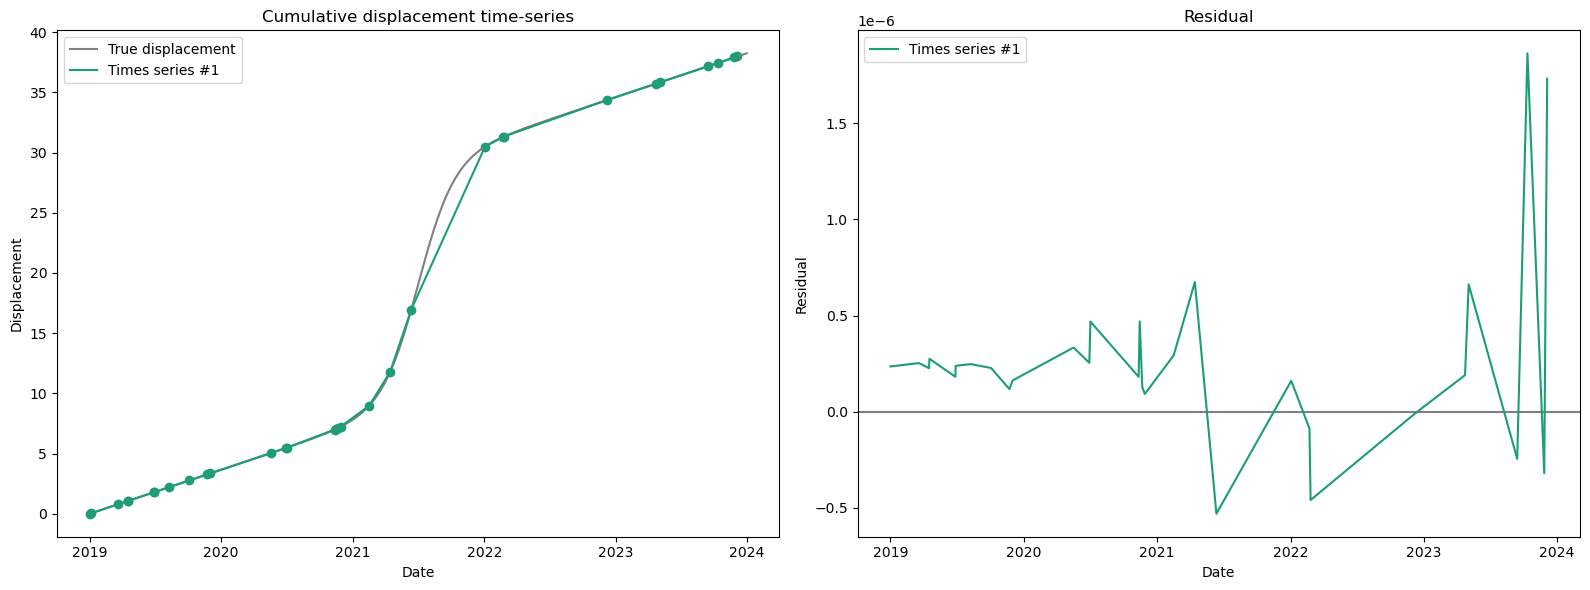

In [4]:
#plot results
inv.plot_timeseries(timeseries, original_signal)

## Simulation of measurement errors

Unlike in this first example, displacement measurements derived from image cross-correlation are usually not free of measurement errors. In the next step, we will simulate the effect of different error types on the inverted time-series.

### Gaussian-distributed errors

Number of image pairs: 465
Number of groups in network: 1


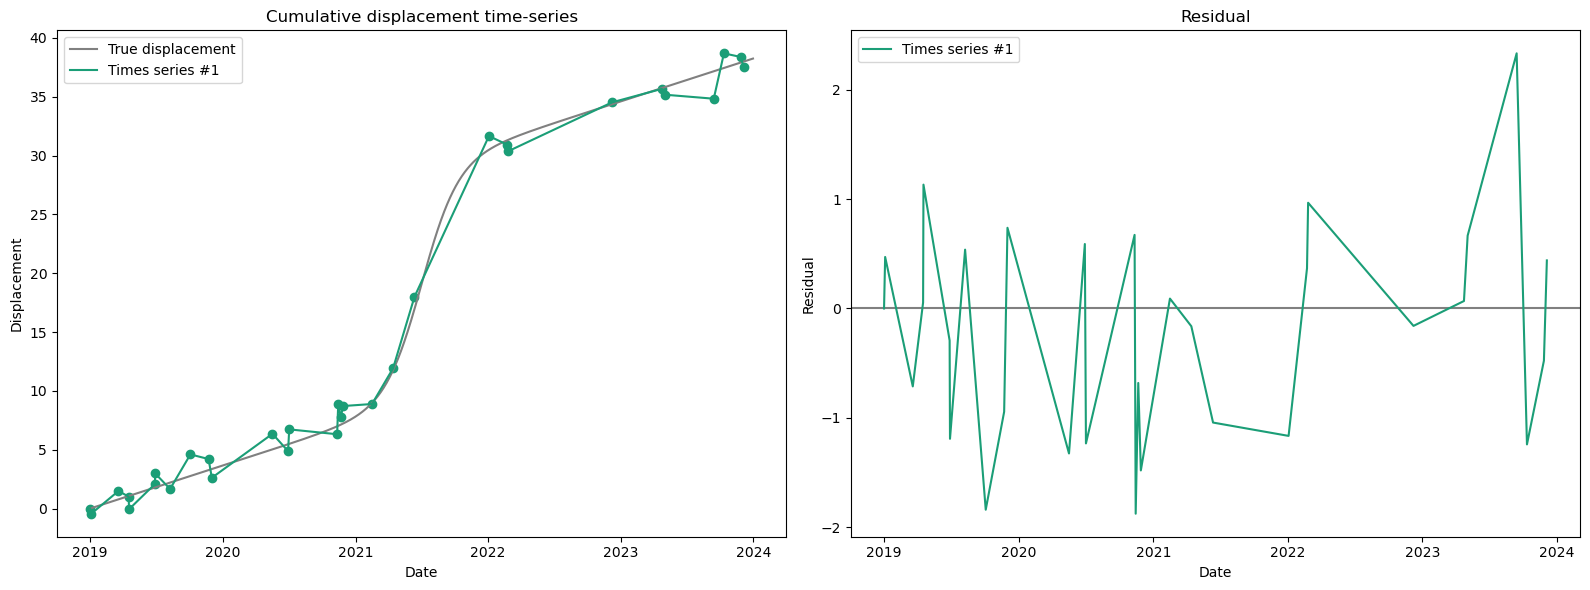

In [5]:
np.random.seed(123)
error = np.random.normal(0,5,len(network))

# add the Gaussian noise to the displacement measured for each date pair
network2 = network.copy()
network2['disp'] = network2.disp + error

#rerun the inversion
timeseries = inv.run_inversion(network2)
inv.plot_timeseries(timeseries, original_signal)

### Fixed-image Gaussian errors

Number of image pairs: 465
Number of groups in network: 1


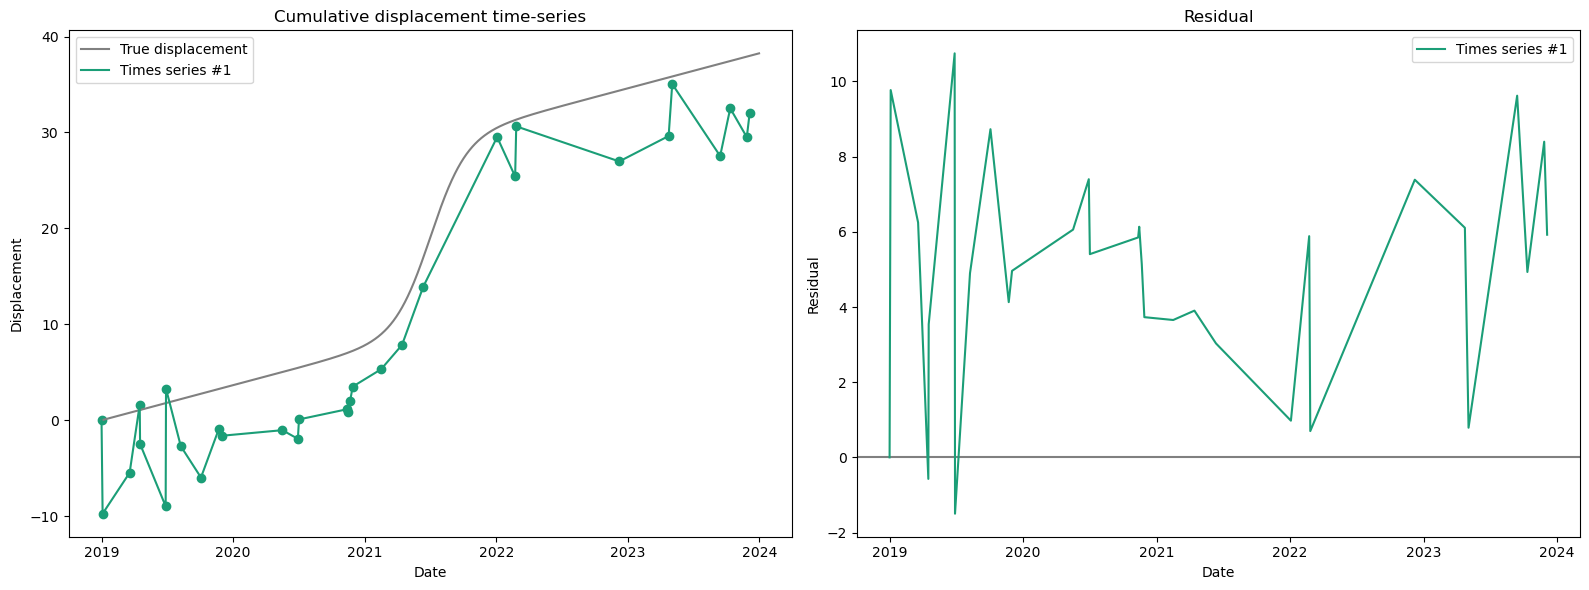

In [6]:
network3 = network.copy()

np.random.seed(123)
#get fixed error value for every image
error = np.random.normal(0,5,len(sample_dates))

#merge error values with network df
m = pd.DataFrame({"date": sample_dates, "error":error})
merge = network3.merge(m, left_on = "date0", right_on = "date")
merge = merge.merge(m, left_on = "date1", right_on = "date")

#measurement error of a correlation pair will be the sum of the error associated with reference and secondary image
error = merge.error_x + merge.error_y 

# add image error to the displacement measured for each date pair
network3['disp'] = network3.disp + error

#rerun the inversion
timeseries = inv.run_inversion(network3)
inv.plot_timeseries(timeseries, original_signal)

### Seasonal errors

Text(0, 0.5, 'Error')

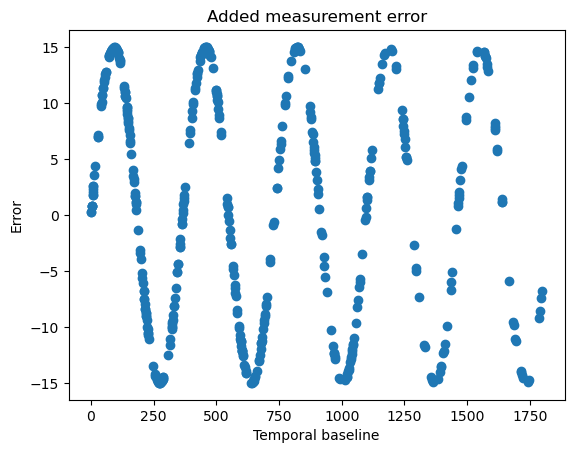

In [7]:
network4 = network.copy()


#define seasonal signal as sine wave with one year wavelength
dt = (network.date1 - network.date0).dt.days
dt_rad = (dt / (365.25/2)) * ( np.pi)

#set wave amplitude to 15
error = np.sin(dt_rad) * 15

plt.figure()
plt.scatter(dt,error)
plt.title("Added measurement error")
plt.xlabel("Temporal baseline")
plt.ylabel("Error")

Number of image pairs: 465
Number of groups in network: 1


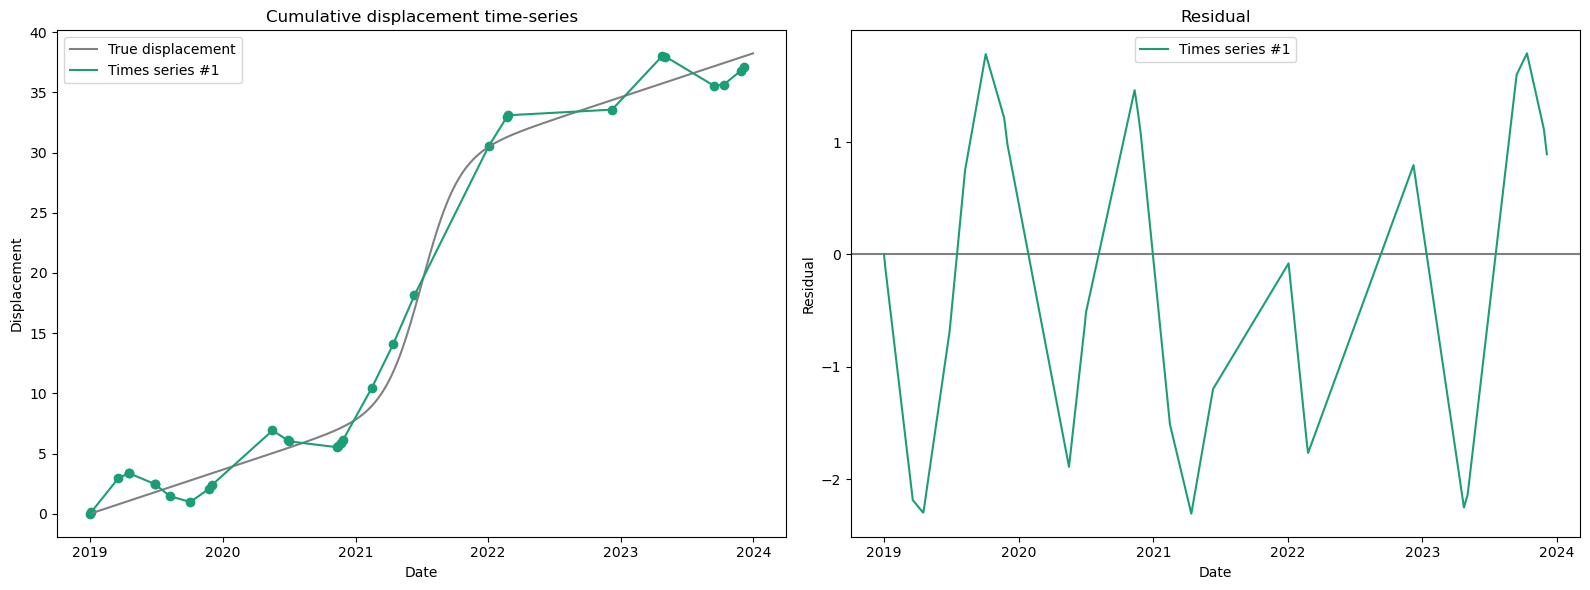

In [8]:
# add seasonal error to the displacement measured for each date pair
network4['disp'] = network4.disp + error

#rerun the inversion
timeseries = inv.run_inversion(network4)
inv.plot_timeseries(timeseries, original_signal)

In [9]:
# save network and timeseries for plotting in R
network4["error"] = error
network4.to_csv("./Rplotting/network_seasonal_error.csv", index = False)

timeseries.to_csv("./Rplotting/timeseries_seasonal_error.csv", index = False)